In [22]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-04-09T01:45:12

CPython 2.7.6
IPython 5.2.2

compiler   : GCC 4.8.4
system     : Linux
release    : 4.4.43-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 1
interpreter: 64bit


In [23]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

1.0.0


In [24]:
%matplotlib inline
from matplotlib import pyplot as plt
import jieba
from jieba import posseg as pseg
from collections import Counter, defaultdict
import random
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

In [25]:
RAW_FILE = 'happiness.txt'

In [27]:

word_cnt = Counter()
segs = []
ngram = 2
DELIMITER = u'.'
with open(RAW_FILE) as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip().decode('utf-8')
        words = pseg.cut(line)
        for word, flag in words:            
            if flag == 'x':
                segs.append(DELIMITER)
            else:
                segs.append(word)                
                word_cnt[word] += 1 
        

In [28]:
print(len(segs))
print(len(word_cnt))

for (w,v) in word_cnt.most_common()[:10]: 
    print w,v  


259688
15899
的 22805
是 4335
在 3525
他 2562
了 2273
人 2245
他们 1811
和 1729
这 1611
有 1534


In [32]:
print(len(word_cnt))

vocab_dict = []
vocab_dict.append('Unknown')

for (w,v) in word_cnt.items():
    if v> 5:
        vocab_dict.append(w)
        
vocab_size = len(vocab_dict)
print(vocab_size)


15899
3520


In [33]:
for w in vocab_dict[:10]:
    print w

Unknown
居于
爱慕
出来
第二
还要
肉体上
少数几个
谈
看作


In [34]:
def get_word_index(word, dicts):
    index = -1
    if word in dicts:
        index = dicts.index(word)
    elif not word == DELIMITER:
        index = 0 #未命中词
    else:
        index = -1 #delimiter, context 输入时忽略，delimiter前后的词被切断，不作为context输入    
    
    return index   

In [36]:
def build_seg_index(raw_segs, dicts):
    seg_index = []
    for seg in raw_segs:
        seg_index.append(get_word_index(seg, dicts))
    return seg_index

In [37]:
segs_index = build_seg_index(segs, vocab_dict)

print(segs_index[:10])

[267, 2237, -1, 1385, 2273, 690, 2988, 3304, 3445, 3467]


In [38]:
def get_input_data(seg_index):
    contexts = []
    labels = []
    for i in range(len(seg_index)-2):
        if (seg_index[i] < 0):
            continue
        if (seg_index[i+1] < 0):            
            continue
        contexts.append([seg_index[i], seg_index[i+1]])
        labels.append(max(0, seg_index[i+2]))
    return (contexts, labels)

In [39]:
#input_data = get_input_data(segs_index)
(input_context, input_labels) = get_input_data(segs_index)

print(len(input_context))
print(len(input_labels))

print(input_context[:10])
print(input_labels[:10])

192236
192236
[[267, 2237], [1385, 2273], [2273, 690], [690, 2988], [2988, 3304], [3304, 3445], [3445, 3467], [3467, 1453], [1453, 2239], [1805, 3165]]
[0, 690, 2988, 3304, 3445, 3467, 1453, 2239, 0, 0]


In [41]:
train_data_size = len(input_context)
batch_size = 100

batch_per_round = (train_data_size / batch_size) + 1
print batch_per_round

1923


In [42]:
tf.reset_default_graph()

In [43]:
# 决定了 embedding 的维度 （隐层节点数）
word_embedding_dim = 100
# 决定了词表数量, 预留一个未登录词

UNK_IDX = 0

# 这里需要把 Word embedding 放到 Variable 里面。因为 Word embedding 是要随机初始化，跟着数据不断变化的。
# 它相当于普通神经网络中的权重。

# 在梯度下降时， tensorflow 的 Optimizer 会自动找到 Graph 中的 Variable，计算梯度并进行更新。
word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))

# placeholder 和 variable 基本都可以当做 Tensor 来用
# 注意这里的输入是 int32 类型，表示一个词 ID。这里我们需要对数据进行预处理，以把高频词映射到 [1, 80000] 之间，不在词表里面的词设置成 UNK, ID 为 0
# 这里我们假设输入是两个词

# 这里 Shape 的第一维我们指定为 None，是表示第一维可以根据数据进行变化，因此同样一个程序可以适应梯度下降时不同的 batch_size
input_data = tf.placeholder(tf.int32, shape=[None, 2], name='input_data')

input_embeds = tf.nn.embedding_lookup(word_embedding, input_data)

# reduce 开头的函数一般有一个 axis 参数，决定按行、按列或者按整个矩阵进行 reduce
context_embeds = tf.reduce_sum(input_embeds, axis=1)

# 激活之前的输出
raw_output = tf.layers.dense(context_embeds, vocab_size)
# 加 softmax 之后的输出
output = tf.nn.softmax(raw_output)

# 样本的 labels 也需要用 placeholder 放置
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

# 因为我们每个样本的 label 只有一个，使用稠密的 softmax 算 cost 及求导太浪费了。这里使用 sparse 版本即可。
# 如果你的 label 是完整的 N 个词上的概率分布，这时候可以使用 tf.nn.softmax_cross_entropy_with_logits
cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=raw_output, labels=labels)

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

In [53]:
epoches = 100
display_steps = 10

cost0 = []
cost1 = []
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(epoches):        
        data_ptr = 0        
        for j in range(batch_per_round):
            if j == batch_per_round-1:
                data_ptr = train_data_size - batch_size
            feed_dict = {input_data: input_context[data_ptr:data_ptr+batch_size],
                             labels: input_labels[data_ptr:data_ptr+batch_size]}
            data_ptr += batch_size
            
            sess.run(train_step, feed_dict=feed_dict)
            
        if (i % display_steps) == 0:
            print("epoch %d" %i)
            cost_train = cost.eval(feed_dict=feed_dict)
            print("Cost: %f, %f" % (cost_train[0], cost_train[1]))
            cost0.append(cost_train[0])
            cost1.append(cost_train[1])
            print("Probability: %f" % output.eval(feed_dict=feed_dict)[0, 3])
            print("------")            
        
    word_embedding_final = sess.run(word_embedding)
    output_final = output.eval(feed_dict=feed_dict)
    
    # Save the variables to disk.
    print("Saving model...")
    save_path = saver.save(sess, "./nn_model.ckpt")
    print("Model saved in file: %s" % save_path)
    

epoch 0
Cost: 1.181928, 3.344592
Probability: 0.000146
------
epoch 10
Cost: 0.315378, 3.774445
Probability: 0.000000
------
epoch 20
Cost: 0.275722, 3.607349
Probability: 0.000000
------
epoch 30
Cost: 0.275230, 3.440222
Probability: 0.000000
------
epoch 40
Cost: 0.274014, 3.288515
Probability: 0.000000
------
epoch 50
Cost: 0.272096, 3.160601
Probability: 0.000000
------
epoch 60
Cost: 0.272738, 3.044067
Probability: 0.000000
------
epoch 70
Cost: 0.275546, 2.957701
Probability: 0.000000
------
epoch 80
Cost: 0.278654, 2.901688
Probability: 0.000000
------
epoch 90
Cost: 0.280777, 2.869469
Probability: 0.000000
------
Saving model...
Model saved in file: ./nn_model.ckpt


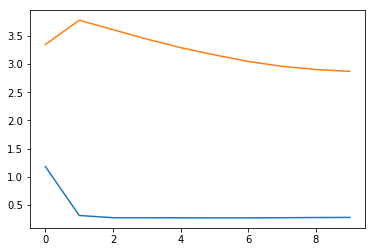

In [54]:
plt.plot(cost0)
plt.plot(cost1)

In [56]:
def get_random_words(cnt, dicts):
    if cnt < 1:
        cnt = 1
    words = []
    index = []
    for i in range(cnt):
        n = random.randrange(0,len(vocab_dict),1)
        words.append(dicts[n])
        index.append(n)
    return words, index
        

In [57]:
def get_cosine_distance_matrix(word_em):
    dist_out = 1-pairwise_distances(word_embedding_final, metric="cosine")
    for i in range(len(dist_out)):
        dist_out[i][i] = 0 #将矩阵对角线设为0，不计算每个词与自己的距离
    return dist_out

In [59]:
word_dist = get_cosine_distance_matrix(word_embedding_final)

In [60]:
def get_nearest_word(index, dist_em, top_count):
    z = dist_em[index].argsort()[-top_count:]
    return z

In [67]:
#从词表中随机抽取3个词，并计算与之最近的10个词
random_words,random_index = get_random_words(3, vocab_dict)

for i in range(len(random_words)):
    index = get_nearest_word(random_index[i], word_dist, 10)
    print index
    print("Nearest words to %s,%d are:" % (random_words[i], random_index[i]))
    for j in index:
        print vocab_dict[10-j+1]

[3178 1370 2213 2242  679 3478 3507 1075 2817  747]
Nearest words to 不准,2781 are:
生命
此后
大海
具备
恶魔
爱情
为了
超出
易
对待
[2996 2465 1780 3111  363 3124 1452  332 3311 3437]
Nearest words to 枯燥无味,2667 are:
少数
消灭
暴君
远远
面对
作出
无论怎样
几乎
一所
相
[3125  898 2844 1398  829 2021 2924   44  219 2226]
Nearest words to 不足以,1183 are:
尽管如此
狭隘
坏事
连续不断
脚趾
内
一类
个体
听到
无益
